# `Scikit-learn` project

### Imports

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

Airbnb has become one of the most used platform to book nights in the last 10 years. By it's size, New York is certainly the city where the paltform is the most present. With a data frame found on [Kaggle](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data) we will try to find the best model to predict the prices of Airbnbs in the big apple. 

# Import the dataset

In [2]:
data_ab_NY = pd.read_csv("AB_NYC_2019.csv")

In [3]:
data_ab_NY

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [4]:
data_ab_NY.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

We first start to find the columns that are not going to interest us. 
- The `id`and the `name` will not interest us because they are distinct for each row.
- The `host_name` is basicly the `host_id` so we can drop it. 

In [5]:
data_ab_NY = data_ab_NY.drop(["id", "name", "host_name"], axis=1)

We now can check the distinct values of the `host_id` to see if we keep the column or not.

In [6]:
print(len(data_ab_NY['host_id']))
print(len(np.unique(data_ab_NY['host_id'])))

48895
37457


There are to many unique values for `host_id`. We decide to drop this column.

In [7]:
data_ab_NY = data_ab_NY.drop("host_id", axis=1)

For the others non-numeric variables, we can do the same check to see if we keep or drop the column.

In [16]:
for var in ["neighbourhood_group", "neighbourhood", "room_type"] :
    print("{} : Number of values :".format(var), len(data_ab_NY[var]), "Number of distinct values : {}".format(len(np.unique(data_ab_NY[var]))))
print("{} : Number of values :".format("last_review"), len(data_ab_NY["last_review"]), "Number of distinct values : {}".format(len(np.unique([str(i) for i in data_ab_NY["last_review"]]))))

neighbourhood_group : Number of values : 48895 Number of distinct values : 5
neighbourhood : Number of values : 48895 Number of distinct values : 221
room_type : Number of values : 48895 Number of distinct values : 3
last_review : Number of values : 48895 Number of distinct values : 1765


The numbers of distinct neighbourhoods and last_reviews are a bit consequent so we decide to drop `neighbourhood` and `last_review`. We can keep `neighbourhood_group` and `room_type`.

In [17]:
data_ab_NY = data_ab_NY.drop("last_review", axis=1)
data_ab_NY = data_ab_NY.drop("neighbourhood", axis=1)

For the column `reviews_per_month` we replace the `NA` values with the mean of the column.

In [18]:
mean = data_ab_NY['reviews_per_month'].mean()
data_ab_NY['reviews_per_month'] = data_ab_NY['reviews_per_month'].fillna(mean)

This is how our dataframe looks like now :

In [19]:
data_ab_NY

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0
...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,40.67853,-73.94995,Private room,70,2,0,1.373221,2,9
48891,Brooklyn,40.70184,-73.93317,Private room,40,4,0,1.373221,2,36
48892,Manhattan,40.81475,-73.94867,Entire home/apt,115,10,0,1.373221,1,27
48893,Manhattan,40.75751,-73.99112,Shared room,55,1,0,1.373221,6,2


Now, two columns are bothering us : `neighbourhood_group` and `room_type`. What we're going to do to resolve this issue is to create a column of `0` and `1` for each occurence of this variable. In order to do that, we use the `get_dummies` function from `pandas`.

In [20]:
data_ab_NY = pd.get_dummies(data_ab_NY, columns=["neighbourhood_group","room_type"])

We can check if we have any `Nan` values in our dataframe :

In [21]:
for i in data_ab_NY.columns :
  print(data_ab_NY[i].isna().any())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


Before scaling the data and make the predictions, we can have a look to the distribution of the prices.

Text(0.5, 1.0, 'Price distribution of NY Airbnbs')

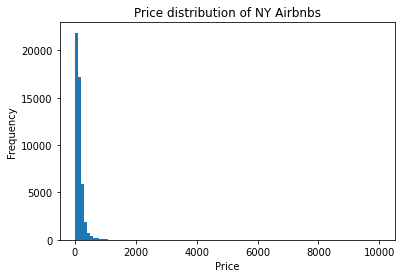

In [22]:
plt.hist(data_ab_NY["price"], bins=100)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price distribution of NY Airbnbs")

Here, we can see that most of the prices are contained between 0 and 2000 dollards. We decide to remove the rows that have a price over 2000 dollards to focus on the most afordables Airbnbs while keeping few high standards locations. 

In [23]:
data_ab_NY = data_ab_NY[(data_ab_NY["price"])<2000]

We can have a look at the new price distribution.

Text(0.5, 1.0, 'Price distribution of NY Airbnbs')

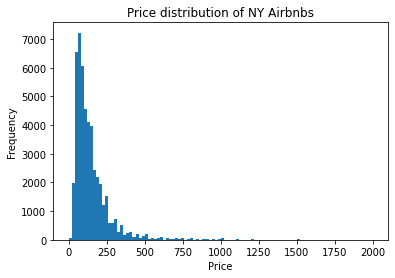

In [24]:
plt.hist(data_ab_NY["price"], bins=100)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price distribution of NY Airbnbs")

Now that we have a dataframe with only numeric values and filtered on the prices, we're going to scale the data to ease the use of them. Before scaling the data we will drop the column `price` because we want to predict it.

In [17]:
X_ab_NY = data_ab_NY.drop("price", axis=1)

In [18]:
scaler = StandardScaler()
scaler.fit(X_ab_NY)
X_scaled = scaler.transform(X_ab_NY)

print("Scaled data")
print(X_scaled)
print("\nMeans")
print(X_scaled.mean(axis=0))
print("\nStandard deviations")
print(X_scaled.std(axis=0))

Scaled data
[[-1.49384920e+00 -4.37652087e-01 -2.93996210e-01 ... -1.04013392e+00
   1.09089297e+00 -1.55887227e-01]
 [ 4.52436023e-01 -6.84639148e-01 -2.93996210e-01 ...  9.61414663e-01
  -9.16680210e-01 -1.55887227e-01]
 [ 1.46839948e+00  2.22496662e-01 -1.96484417e-01 ... -1.04013392e+00
   1.09089297e+00 -1.55887227e-01]
 ...
 [ 1.57348017e+00  7.58210126e-02  1.44806857e-01 ...  9.61414663e-01
  -9.16680210e-01 -1.55887227e-01]
 [ 5.23773529e-01 -8.43880805e-01 -2.93996210e-01 ... -1.04013392e+00
  -9.16680210e-01  6.41489377e+00]
 [ 6.43525178e-01 -8.05099504e-01 -1.46083215e-03 ... -1.04013392e+00
   1.09089297e+00 -1.55887227e-01]]

Means
[ 3.92689846e-14  1.66097412e-13  1.10443293e-17  1.86009756e-17
  2.79014634e-17 -1.86009756e-17  0.00000000e+00  4.65024390e-18
  1.25556585e-16 -3.48768292e-18 -6.74285365e-17 -1.33694512e-17
 -9.47487194e-17 -1.16256097e-18  1.86009756e-17]

Standard deviations
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


All means are close to `0` and all standard deviations are equals to `1`. Our datas are perfectly scaled.

# Creation of train and test dataframes

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data_ab_NY["price"], test_size=0.33, random_state=42, shuffle=True)

# Models comparison

To compare our models we will use the Residual Mean Square Error also called RMSE. its formula is : $RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{\hat{y_i} -y_i}{\sigma_i}\Big)^2}}$ with $\hat{y_i}$ being the predicted values and $y_i$ the real values.

# Linear models

In this section, we will try three linear models from the `sklearn.linear_model` library. The three models we will try are : 

* `LinearRegression`
* `Ridge`
* `Lasso`

For each of theses models we will :

1.  Search the best parameters by cross validation 
2.  Create a model with the best parameters
3. Compute the mean squared error 





## `LinearRegression`

### Searching the best parameters

In [20]:
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

lr_grid_search = GridSearchCV(estimator=LinearRegression(),
                             param_grid=parameters,
                             scoring='neg_mean_squared_error',
                             cv=5,
                             n_jobs=-1)

lr_grid_search.fit(X_train, y_train)

lr_best_parameters = lr_grid_search.best_params_  
lr_best_score = lr_grid_search.best_score_ 
print(lr_best_parameters)

{'copy_X': True, 'fit_intercept': True}


### Creating a model with the best parameters

In [21]:
lr_best_model = LinearRegression(copy_X=lr_best_parameters["copy_X"], fit_intercept=lr_best_parameters["fit_intercept"])

lr_best_model.fit(X_train, y_train)

lr_prediction = lr_best_model.predict(X_test)

### Computing the RMSE (Residual mean square error)

In [22]:
lr_error = mean_squared_error(y_test, lr_prediction)
print(np.sqrt(lr_error))

188.94297571947786


## `Ridge`

### Searching the best parameters

In [23]:
alphas = np.array([1,0.4,0.1,0.01,0.001,0.0001])
fit_intercept = [True, False]
copy_X = [True, False]

ridge_parameters = {"alpha" : alphas, "fit_intercept":fit_intercept, "copy_X" : copy_X}

ridge_grid_search = GridSearchCV(estimator=Ridge(),  
                         param_grid=ridge_parameters,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         n_jobs=-1)

ridge_grid_search.fit(X_train, y_train)

ridge_best_parameters = ridge_grid_search.best_params_  
ridge_best_score = ridge_grid_search.best_score_ 
print(ridge_best_parameters)
print(ridge_best_score)

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True}
-60093.9100264733


### Creating a model with the best parameters

In [24]:
ridge_best_model = Ridge(alpha=1, copy_X=True, fit_intercept=True)

ridge_best_model.fit(X_train, y_train)

ridge_prediction = ridge_best_model.predict(X_test)

### Compute the RMSE (Residual mean square error)

In [25]:
ridge_error = mean_squared_error(y_test, ridge_prediction)
print(np.sqrt(ridge_error))

188.95527065972266


## `Lasso`

### Searching the best parameters

In [ ]:
alphas = np.array([1,0.4,0.1,0.01,0.001,0.0001,0])
fit_intercept = [True, False]
copy_X = [True, False]
max_iter = [500, 1000, 2000, 3000]

lasso_parameters = {"alpha":alphas, "fit_intercept": fit_intercept, "copy_X" : copy_X, "max_iter" : max_iter}

lasso_grid_search = GridSearchCV(estimator=Lasso(),  
                         param_grid=lasso_parameters,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         n_jobs=-1)

lasso_grid_search.fit(X_train, y_train)

lasso_best_parameters = lasso_grid_search.best_params_  
lasso_best_score = lasso_grid_search.best_score_ 
print(lasso_best_parameters)
print(lasso_best_score)

### Creating a model with the best parameters

In [28]:
lasso_best_model = Lasso(alpha=lasso_best_parameters["alpha"],
                         copy_X=lasso_best_parameters["copy_X"],
                         fit_intercept=lasso_best_parameters["fit_intercept"], 
                         max_iter= lasso_best_parameters["max_iter"])

lasso_best_model.fit(X_train, y_train)

lasso_prediction = lasso_best_model.predict(X_test)

### Computing the RMSE (residual mean square error)

In [29]:
lasso_error = mean_squared_error(y_test, lasso_prediction)
print(np.sqrt(lasso_error))

188.94193817371195


Here we saw that all three linear regression models have slightly the sames RMSE. We decide to check other models to see if we can drop the RMSE. In the next sections we will see the Random forests and Gradient boosting.

# Random forest

## `RandomForestRegressor`

### Searching the best parameters

In [30]:
max_depth = [1,2,5,10]
min_samples_split = [2,3,5,10]
n_estimators = [50, 100, 200]

rf_parameters = {"max_depth" : max_depth, "min_samples_split" : min_samples_split, "n_estimators" : n_estimators}

rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(),  
                         param_grid=rf_parameters,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         n_jobs=-1)

rf_grid_search.fit(X_train, y_train)

rf_best_parameters = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_
print(rf_best_parameters)
print(rf_best_score)

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
-59951.64986004003


### Model with the best parameters

In [31]:
best_rf = RandomForestRegressor(max_depth=rf_best_parameters["max_depth"], min_samples_split = rf_best_parameters["min_samples_split"], n_estimators=rf_best_parameters["n_estimators"])
best_rf.fit(X_train,y_train)
pred_rf = best_rf.predict(X_test)

### Computing the RMSE (residual mean square error)

In [32]:
error_rf = mean_squared_error(y_test, pred_rf)
print(np.sqrt(error_rf))

184.74031365147698


The RMSE is lower than with the linear models, for the moment, this model is the best we found.

# Gradient Boosting

## `GradientBosstingRegressor`

### Searching the best parameters

In [34]:
learning_rate = [0.01, 0.1, 0.5]
min_samples_split = [2,5,10, 20]
n_estimators = [100, 300]

gbr_parameters = {"learning_rate" : learning_rate, 
                  "min_samples_split" : min_samples_split, 
                  "n_estimators" : n_estimators}

gbr_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(),  
                         param_grid=gbr_parameters,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         n_jobs=-1)

gbr_grid_search.fit(X_train, y_train)

gbr_best_parameters = gbr_grid_search.best_params_
gbr_best_score = gbr_grid_search.best_score_
print(gbr_best_parameters)
print(gbr_best_score)

{'learning_rate': 0.1, 'min_samples_split': 2, 'n_estimators': 100}
-59376.42041781595


### Model with the best parameters

In [35]:
gbr_model = GradientBoostingRegressor(learning_rate = gbr_best_parameters["learning_rate"], 
                                      min_samples_split = gbr_best_parameters["min_samples_split"], 
                                      n_estimators = gbr_best_parameters["n_estimators"])

gbr_model.fit(X_train, y_train)

gbr_prediction = gbr_model.predict(X_test)

### Compute the RMSE (Residual mean square error)

In [36]:
gbr_error = mean_squared_error(y_test, gbr_prediction)
print(np.sqrt(gbr_error))

183.86461426307181


The RMSE is lower than the Random forest's one. This model is the best one we hve for the moment.

# PCA

We're going to use the PCA with `GradientBoostingRegressor` because it got the lower RMSE. We'll try to get a lower RMSE with the PCA.

## PCA with `GradientBoostingRegressor`

In [ ]:
gbr_pca_pipe = Pipeline([('pca', PCA() ), ('GradientBoostingRegressor', GradientBoostingRegressor(learning_rate = gbr_best_parameters["learning_rate"], 
                                      min_samples_split = gbr_best_parameters["min_samples_split"], 
                                      n_estimators = gbr_best_parameters["n_estimators"])
)])

parameters = {'pca__n_components':np.arange(1,20,1)}
gbr_pca = GridSearchCV(gbr_pca_pipe, parameters, scoring = 'neg_mean_squared_error', n_jobs=-1)

gbr_pca.fit(X_train,y_train)

In [42]:
print(gbr_pca.best_estimator_)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('GradientBoostingRegressor', GradientBoostingRegressor())])


In [43]:
pred_gbr_pca = gbr_pca.predict(X_test)

error_gbr_pca = mean_squared_error(y_test, pred_gbr_pca)

print(np.sqrt(error_gbr_pca))

197.0741819764945


We can see here that the RMSE is higher than the one found with the `GradientBoostingRegressor`. The PCA does not create a beter model.

# Model selection

From the six models we tried, the on that have the lower RMSE is `GradientBoostingRegressor`. We can still represent the RMSE of our six algorithms to compare them.

In [46]:
model = ["LinearRegression", "Ridge", "Lasso", "RandomForestRegressor", "GradientBoostingRegressor", "GradientBoostingRegressor_PCA"]
RMSE = [np.sqrt(lr_error), np.sqrt(ridge_error), np.sqrt(lasso_error), np.sqrt(error_rf), np.sqrt(gbr_error), np.sqrt(error_gbr_pca)]
df_scores = pd.DataFrame({"model" : model, "RMSE" : RMSE})
df_scores = df_scores.sort_values(by=['RMSE'])

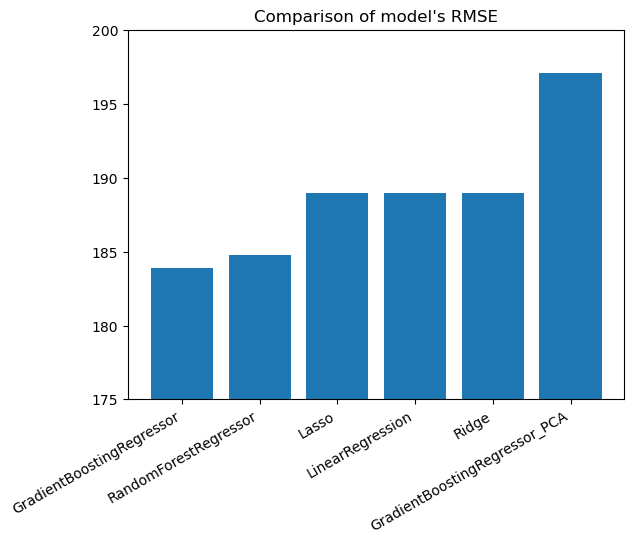

In [54]:
plt.bar(df_scores["model"], df_scores["RMSE"])
plt.ylim(175,200)
plt.xticks(rotation=30, ha='right')
plt.title("Comparison of model's RMSE")
plt.show()

We can clearly see with this representation that `GradientBoostingRegressor` is the best model followed by `RandomForestRegressor` and then by the three linear models that have almost the same RMSE. The PCA on `RandonForestRegressor` wasn't great and had the worst RMSE. 